# Gradient Boost Classifier (GBC) as model
*by Max*

In this notebook we will fit our data via GBC models. Here we use both, the raw band information and the calculated spectral indices. We start by loading the needed modules and the data.

In [ ]:
# set the directory of the data
# depending on colab or vscode environment
on_colabs = True
import sys
if on_colabs:
  from google.colab import drive
  drive.mount('/content/drive')
  OUTPUT_DIR = "/content/drive/MyDrive/Radiant_Earth_Spot_Crop/data"
  sys.path.append("/content/drive/MyDrive/Radiant_Earth_Spot_Crop/src")
else:
  OUTPUT_DIR = "../data"
  sys.path.append("../src/")

Mounted at /content/drive


In [85]:
# import the needed modules
import numpy as np
import pandas as pd

# import the machine learning modules
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, DMatrix, cv
from sklearn.model_selection import GridSearchCV 
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import hyperopt.pyll.stochastic
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, classification_report

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# import plotting modules and style
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme(context='notebook', style='darkgrid', palette='crest', font='helvetica')
cmap = sns.color_palette('crest')
sns.set(rc = {"figure.dpi":300})
sns.set(rc = {"figure.figsize":(6,3)})
sns.set(font_scale = 0.5)

# import own modules from the scr folder
from train_test_function import train_test_split_fields

# set a random seed
RSEED = 42
np.random.seed(RSEED)

In [ ]:
# load the base data from the CSV files
df = pd.read_csv(f"{OUTPUT_DIR}/Train.csv")
df

,field_id,B02_04,B02_05,B02_06,B02_07,B02_08,B02_09,B02_10,B02_11,B03_04,...,WET_11,PVR_04,PVR_05,PVR_06,PVR_07,PVR_08,PVR_09,PVR_10,PVR_11,label
0,1,16.721329,24.704984,143.294212,120.819938,44.800108,16.204582,84.610932,71.071544,24.630225,...,1.962072,-0.129347,-0.118203,-0.027443,0.040792,0.171888,0.038998,-0.064742,-0.069020,4
1,2,32.724639,55.923914,125.333332,69.246375,40.289855,40.369565,56.710145,121.275364,42.333333,...,7.068886,-0.146733,-0.087567,-0.032327,0.022328,0.115969,-0.060363,-0.128947,-0.093419,7
2,4,32.280353,34.968543,154.134656,98.110374,37.219647,16.107616,37.224062,49.027595,43.079471,...,-27.280756,-0.123696,-0.118763,-0.029688,0.046448,0.043605,0.055476,-0.027601,-0.118679,8
3,6,18.155303,31.757102,145.524621,108.803978,60.709280,33.967330,53.688447,106.650568,28.818182,...,11.352537,-0.118640,-0.073378,-0.001560,0.080290,0.042376,0.018127,0.021250,0.000732,4
4,8,24.826734,79.171811,105.283333,74.694014,68.673711,13.678272,50.742448,111.811466,39.079529,...,5.653202,-0.209057,-0.126597,-0.055015,-0.009886,0.056202,-0.122661,-0.154477,-0.103681,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152374,121040,20.403039,59.414845,80.847889,27.824667,59.708337,81.547986,46.761128,67.944430,33.696896,...,-41.660880,-0.183287,-0.130227,-0.083794,-0.111953,-0.087094,-0.080153,-0.126261,-0.119986,9
152375,81419,43.263652,64.798399,70.318978,31.452927,53.690466,67.588925,76.104462,72.158007,57.171448,...,-43.322944,-0.194625,-0.165170,-0.121343,-0.184359,-0.155505,-0.130677,-0.168950,-0.146476,9
152376,120632,24.294387,80.966079,97.427150,82.883655,68.383974,62.480107,85.343281,75.238125,40.287612,...,-37.588233,-0.209406,-0.139067,-0.101158,-0.086092,-0.092242,-0.099815,-0.094287,-0.123467,9
152377,55097,23.256538,46.628218,94.869888,35.849067,70.241120,41.519023,44.394830,68.003466,39.282254,...,-49.131428,-0.155267,-0.089067,-0.099821,-0.116138,-0.090815,-0.125115,-0.128937,-0.115460,9


---
## Train-test split, validation split & resampling
Next we do the train-test split and also a validation split.

In [ ]:
# do the train-test-split
df_train, df_test = train_test_split_fields(
    df, train_size=0.7, random_state=RSEED
)

# do the validation split
df_train_val, df_test_val = train_test_split_fields(
    df_train, train_size=0.7, random_state=RSEED
)

We setup the the features (X) and the target (y) for the validation train and test data.

In [ ]:
# get X for the train and validation data
X_train = df_train_val.drop(columns=["label", "field_id"])
X_val = df_test_val.drop(columns=["label", "field_id"])

# get y for the train and validation data
y_train = df_train_val["label"]
y_train = y_train.astype(int)
y_val = df_test_val["label"]
y_val = y_val.astype(int)

# set the classes from 0 to 8 
y_train = y_train-1
y_val = y_val-1

---
## Modelling with XGBoost
We will start this process by using the XGBClassifier with the default hyperparameters (only objective, evaluation metric and GPU support are given).


In [ ]:
# initialize a default GradientBoostingClassifier
xgb = XGBClassifier(
    objective='multi:softprob', 
    num_class='9',
    eval_metric='mlogloss', 
    disable_default_eval_metric=1, 
    random_state=RSEED,
    n_jobs = -1, 
    tree_method='gpu_hist', 
    gpu_id=0
    )
xgb.fit(X_train, y_train)

XGBClassifier(disable_default_eval_metric=1, eval_metric='mlogloss', gpu_id=0,
              n_jobs=-1, num_class='9', objective='multi:softprob',
              random_state=42, tree_method='gpu_hist')

In [ ]:
# predict the absolute classes and probabilities
y_pred_train = xgb.predict(X_train)
y_pred_val = xgb.predict(X_val)

# predict the probabilities for each  class
y_proba_train = xgb.predict_proba(X_train)
y_proba_val = xgb.predict_proba(X_val)

In [ ]:
print("---" * 12)
print(f"Accuracy on train data: {round(accuracy_score(y_train, y_pred_train), 3)}")
print(f"Accuracy on test data: {round(accuracy_score(y_val, y_pred_val), 3)}")
print("---" * 12)
print(f'F1-score on train data: {round(f1_score(y_train, y_pred_train, average="macro"), 3)}')
print(f'F1-score on test data: {round(f1_score(y_val, y_pred_val, average="macro"), 3)}')
print("---" * 12)
print(f"Cross-entropy on train data: {round(log_loss(y_train, y_proba_train), 3)}")
print(f"Cross-entropy on test data: {round(log_loss(y_val, y_proba_val), 3)}")
print("---" * 12)

------------------------------------
Accuracy on train data: 0.613
Accuracy on test data: 0.596
------------------------------------
F1-score on train data: 0.603
F1-score on test data: 0.588
------------------------------------
Cross-entropy on train data: 1.121
Cross-entropy on test data: 1.159
------------------------------------


In [ ]:
xgb.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'disable_default_eval_metric': 1,
 'eval_metric': 'mlogloss',
 'gamma': 0,
 'gpu_id': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'nthread': None,
 'num_class': '9',
 'objective': 'multi:softprob',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'tree_method': 'gpu_hist',
 'verbosity': 1}

---
## Hyperparameter tuning via Bayesian optimization
The next step is the tuning of the hyperparameters. We will try a new method, the Bayesian optimization via the hyperopt module.

In [ ]:
# hp.uniform for float number
# hp.quniform for int that are a multiple from the last number, 
# for example 3, 15, 1 means any whole number between 3 and 15
space={
    'objective': hp.choice('objective', ('multi:softmax', 'multi:softprob')),
    'n_estimators': 150,
    'random_state': RSEED,
    'disable_default_eval_metric': 1,
    'gpu_id':0,
    'tree_method': 'gpu_hist',
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 3, 1),
    'gamma': hp.uniform ('gamma', 0, 0.3),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.9),
    'learning_rate': hp.uniform('learning_rate', 0, 1)
    }
print(hyperopt.pyll.stochastic.sample(space))

{'colsample_bytree': 0.6736700345116272, 'disable_default_eval_metric': 1, 'gamma': 0.21808876574146818, 'gpu_id': 0, 'learning_rate': 0.1704460087837808, 'max_depth': 7.0, 'min_child_weight': 2.0, 'n_estimators': 150, 'objective': 'multi:softmax', 'random_state': 42, 'tree_method': 'gpu_hist'}


In [ ]:
def objective(space):
    clf = XGBClassifier(
        objective=space['objective'],
        n_estimators=space['n_estimators'],
        random_state=space['random_state'],
        disable_default_eval_metric=space['disable_default_eval_metric'],
        gpu_id=space['gpu_id'],
        tree_method=space['tree_method'],
        max_depth=int(space['max_depth']),
        min_child_weight=int(space['min_child_weight']),
        gamma=space['gamma'],
        colsample_bytree=int(space['colsample_bytree']),
        learning_rate=space['learning_rate']
    )
    
    evaluation = [
                  ( X_train, y_train), 
                  ( X_val, y_val)
    ]
                
    clf.fit(
        X_train, y_train,
        eval_set=evaluation, 
        eval_metric="mlogloss",
        early_stopping_rounds=10,
        verbose=False
    )
    
    y_pred_val = clf.predict(X_val)
    f1 = f1_score(y_val, y_pred_val, average="macro")
    print ("SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

SCORE:
0.47219669199373243
SCORE:
0.5197774886461075
SCORE:
0.40962504866311966
SCORE:
0.4407405965087248
SCORE:
0.4961047385743796
SCORE:
0.5471558291154088
SCORE:
0.5189418385290329
SCORE:
0.5582040125730844
SCORE:
0.4808647095763652
SCORE:
0.5465990695826481
SCORE:
0.534716582208193
SCORE:
0.5379084779838463
SCORE:
0.5127058101986164
SCORE:
0.5120474348180355
SCORE:
0.5419287753208645
SCORE:
0.5176021047735042
SCORE:
0.5425539648429414
SCORE:
0.5080167186938135
SCORE:
0.5063810816218495
SCORE:
0.4925100959109219
SCORE:
0.5533805590751504
SCORE:
0.5543889382825005
SCORE:
0.5391873837380717
SCORE:
0.5550543746342592
SCORE:
0.5307272490344901
SCORE:
0.5559830318296046
SCORE:
0.5330511435570651
SCORE:
0.5424798941625419
SCORE:
0.5606260962876872
SCORE:
0.527853149376343
SCORE:
0.5600817408342198
SCORE:
0.5397538386015633
SCORE:
0.5523544313345423
SCORE:
0.507814352262528
SCORE:
0.49266705580619685
SCORE:
0.34387718305120374
SCORE:
0.5278192939016177
SCORE:
0.5414150857154123
SCORE:
0.54

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.655349597562582, 'gamma': 0.09019240188259454, 'max_depth': 9.0, 'min_child_weight': 2.0, 'objective': 0}


---
## Second round of improvement via Bayesian optimization

In [ ]:
# hp.uniform for float number
# hp.quniform for int that are a multiple from the last number, 
# for example 3, 15, 1 means any whole number between 3 and 15
space={
    'objective': 'multi:softmax',
    'n_estimators': hp.quniform('n_estimators', 50, 500, 10),
    'random_state': RSEED,
    'disable_default_eval_metric': 1,
    'gpu_id':0,
    'tree_method': 'gpu_hist',
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'gamma': hp.uniform ('gamma', 0, 5),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.9),
    'learning_rate': hp.uniform('learning_rate', 0, 5)
    }
print(hyperopt.pyll.stochastic.sample(space))

{'colsample_bytree': 0.6696240766878037, 'disable_default_eval_metric': 1, 'gamma': 4.683339319269378, 'gpu_id': 0, 'learning_rate': 4.096092220744751, 'max_depth': 3.0, 'min_child_weight': 0.0, 'n_estimators': 420.0, 'objective': 'multi:softmax', 'random_state': 42, 'tree_method': 'gpu_hist'}


In [ ]:
def objective(space):
    clf = XGBClassifier(
        objective=space['objective'],
        n_estimators=int(space['n_estimators']),
        random_state=space['random_state'],
        disable_default_eval_metric=space['disable_default_eval_metric'],
        gpu_id=space['gpu_id'],
        tree_method=space['tree_method'],
        max_depth=int(space['max_depth']),
        min_child_weight=int(space['min_child_weight']),
        gamma=space['gamma'],
        colsample_bytree=space['colsample_bytree'],
        learning_rate=space['learning_rate']
    )
    
    evaluation = [( X_train, y_train), ( X_val, y_val)]
    
    clf.fit(
        X_train, y_train,
        eval_set=evaluation, 
        eval_metric="mlogloss",
        early_stopping_rounds=10,
        verbose=False
    )
    
    y_pred_val = clf.predict(X_val)
    f1 = f1_score(y_val, y_pred_val, average="macro")
    print ("SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:
0.7445535271669521
SCORE:
0.5353837257813621
SCORE:
0.5493731856361427
SCORE:
0.5555502127106511
SCORE:
0.7136435703453707
SCORE:
0.5704124087344719
SCORE:
0.5723199849271998
SCORE:
0.5682165169483482
SCORE:
0.7662627922775729
SCORE:
0.7581258894680842
SCORE:
0.7793541831939065
SCORE:
0.400153297534228
SCORE:
0.5675888419782156
SCORE:
0.7277564171258172
SCORE:
0.8096542447159898
SCORE:
0.5815518341359591
SCORE:
0.7816636071626948
SCORE:
0.7750514368603478
SCORE:
0.5844744694479505
SCORE:
0.47250400054115654
SCORE:
0.8052404105461439
SCORE:
0.7731492372989301
SCORE:
0.7646954847877768
SCORE:
0.7984153562320055
SCORE:
0.7226661548118507
SCORE:
0.5637934749704635
SCORE:
0.7422758261567854
SCORE:
0.796097429533845
SCORE:
0.7288049695299406
SCORE:
0.6712989351252342
SCORE:
0.5267234088909876
SCORE:
0.7896457007831427
SCORE:
0.5777586817300217
SCORE:
0.7637189180081683
SCORE:
0.7967547957083002
SCORE:
0.5714001190992924
SCORE:
0.7842978697171711
SCORE:
0.7574600727294425
SCORE:
0.4845

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.5777187270022676, 'gamma': 1.377784932836379, 'learning_rate': 0.10161907358428368, 'max_depth': 14.0, 'min_child_weight': 6.0, 'n_estimators': 480.0}


The best hyperparameters for a F1-score of 0.81 are:  

{'colsample_bytree': 0.5777187270022676, 'gamma': 1.377784932836379, 'learning_rate': 0.10161907358428368, 'max_depth': 14.0, 'min_child_weight': 6.0, 'n_estimators': 480.0}

In [ ]:
# initialize a default GradientBoostingClassifier
xgb = XGBClassifier(
    objective='multi:softmax', 
    n_estimators=480,
    random_state=RSEED,
    disable_default_eval_metric=1,
    gpu_id=0,
    tree_method='gpu_hist',
    max_depth=14,
    min_child_weight=6,
    gamma=1.377784932836379,
    colsample_bytree=0.5777187270022676,
    learning_rate=0.10161907358428368
    )
xgb.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.5777187270022676,
              disable_default_eval_metric=1, gamma=1.377784932836379, gpu_id=0,
              learning_rate=0.10161907358428368, max_depth=14,
              min_child_weight=6, n_estimators=480, objective='multi:softprob',
              random_state=42, tree_method='gpu_hist')

In [ ]:
# predict the absolute classes and probabilities
y_pred_train = xgb.predict(X_train)
y_pred_val = xgb.predict(X_val)

# predict the probabilities for each  class
y_proba_train = xgb.predict_proba(X_train)
y_proba_val = xgb.predict_proba(X_val)

In [ ]:
print("---" * 12)
print(f"Accuracy on train data: {round(accuracy_score(y_train, y_pred_train), 3)}")
print(f"Accuracy on test data: {round(accuracy_score(y_val, y_pred_val), 3)}")
print("---" * 12)
print(f'F1-score on train data: {round(f1_score(y_train, y_pred_train, average="macro"), 3)}')
print(f'F1-score on test data: {round(f1_score(y_val, y_pred_val, average="macro"), 3)}')
print("---" * 12)
print(f"Cross-entropy on train data: {round(log_loss(y_train, y_proba_train), 3)}")
print(f"Cross-entropy on test data: {round(log_loss(y_val, y_proba_val), 3)}")
print("---" * 12)

------------------------------------
Accuracy on train data: 1.0
Accuracy on test data: 0.811
------------------------------------
F1-score on train data: 1.0
F1-score on test data: 0.81
------------------------------------
Cross-entropy on train data: 0.016
Cross-entropy on test data: 0.569
------------------------------------


---
## Third round of improvement via Bayesian optimization


In [ ]:
# hp.uniform for float number
# hp.quniform for int that are a multiple from the last number, 
# for example 3, 15, 1 means any whole number between 3 and 15
space={
    'objective': 'multi:softmax',
    'n_estimators': hp.quniform('n_estimators', 200, 1000, 10),
    'random_state': RSEED,
    'disable_default_eval_metric': 1,
    'gpu_id':0,
    'tree_method': 'gpu_hist',
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'gamma': hp.uniform ('gamma', 0, 5),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.9),
    'learning_rate': hp.uniform('learning_rate', 0, 5)
    }
print(hyperopt.pyll.stochastic.sample(space))

{'colsample_bytree': 0.6251462441298007, 'disable_default_eval_metric': 1, 'gamma': 4.139708533870761, 'gpu_id': 0, 'learning_rate': 2.6073990876218325, 'max_depth': 10.0, 'min_child_weight': 2.0, 'n_estimators': 220.0, 'objective': 'multi:softmax', 'random_state': 42, 'tree_method': 'gpu_hist'}


In [ ]:
def objective(space):
    clf = XGBClassifier(
        objective=space['objective'],
        n_estimators=int(space['n_estimators']),
        random_state=space['random_state'],
        disable_default_eval_metric=space['disable_default_eval_metric'],
        gpu_id=space['gpu_id'],
        tree_method=space['tree_method'],
        max_depth=int(space['max_depth']),
        min_child_weight=int(space['min_child_weight']),
        gamma=space['gamma'],
        colsample_bytree=space['colsample_bytree'],
        learning_rate=space['learning_rate']
    )
    
    evaluation = [( X_train, y_train), ( X_val, y_val)]
    
    clf.fit(
        X_train, y_train,
        eval_set=evaluation, 
        eval_metric="mlogloss",
        early_stopping_rounds=10,
        verbose=False
    )
    
    y_pred_val = clf.predict(X_val)
    f1 = f1_score(y_val, y_pred_val, average="macro")
    print ("SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 200,
                        trials = trials)

SCORE:
0.5699471345907683
SCORE:
0.5665041377901722
SCORE:
0.452613423965021
SCORE:
0.5640723344487111
SCORE:
0.7784085997374575
SCORE:
0.5645992220741968
SCORE:
0.5195492500572942
SCORE:
0.4722687491741827
SCORE:
0.7930725578330329
SCORE:
0.7742981640891553
SCORE:
0.5258647391496317
SCORE:
0.777460043686136
SCORE:
0.7329423222599872
SCORE:
0.45243359315231324
SCORE:
0.5447898754007858
SCORE:
0.5671985361021032
SCORE:
0.5657674760410557
SCORE:
0.5502723868657973
SCORE:
0.5820890447228972
SCORE:
0.5015184200322941
SCORE:
0.7893736008773651
SCORE:
0.7987975599149415
SCORE:
0.7845737480621453
SCORE:
0.7983243432552397
SCORE:
0.7592755501299566
SCORE:
0.7975579391133286
SCORE:
0.7561542243044752
SCORE:
0.7872824607390518
SCORE:
0.8083712912494968
SCORE:
0.7871807438145368
SCORE:
0.7432416996133944
SCORE:
0.7779185571577508
SCORE:
0.5519876150117375
SCORE:
0.7636992581910191
SCORE:
0.7639825324622053
SCORE:
0.7826016189910884
SCORE:
0.4026286019772257
SCORE:
0.7967509460656977
SCORE:
0.7830

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.5386703492872202, 'gamma': 2.3949368144857046, 'learning_rate': 0.08063286610555805, 'max_depth': 12.0, 'min_child_weight': 5.0, 'n_estimators': 880.0}


{'colsample_bytree': 0.5386703492872202, 'gamma': 2.3949368144857046, 'learning_rate': 0.08063286610555805, 'max_depth': 12.0, 'min_child_weight': 5.0, 'n_estimators': 880.0}


In [ ]:
# initialize a default GradientBoostingClassifier
xgb = XGBClassifier(
    objective='multi:softmax', 
    n_estimators=880,
    random_state=RSEED,
    disable_default_eval_metric=1,
    gpu_id=0,
    tree_method='gpu_hist',
    max_depth=12,
    min_child_weight=5,
    gamma=2.3949368144857046,
    colsample_bytree=0.5386703492872202,
    learning_rate=0.08063286610555805
    )
xgb.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.5386703492872202,
              disable_default_eval_metric=1, gamma=2.3949368144857046, gpu_id=0,
              learning_rate=0.08063286610555805, max_depth=12,
              min_child_weight=5, n_estimators=880, objective='multi:softprob',
              random_state=42, tree_method='gpu_hist')

In [ ]:
# predict the absolute classes and probabilities
y_pred_train = xgb.predict(X_train)
y_pred_val = xgb.predict(X_val)

# predict the probabilities for each  class
y_proba_train = xgb.predict_proba(X_train)
y_proba_val = xgb.predict_proba(X_val)

In [ ]:
print("---" * 12)
print(f"Accuracy on train data: {round(accuracy_score(y_train, y_pred_train), 3)}")
print(f"Accuracy on test data: {round(accuracy_score(y_val, y_pred_val), 3)}")
print("---" * 12)
print(f'F1-score on train data: {round(f1_score(y_train, y_pred_train, average="macro"), 3)}')
print(f'F1-score on test data: {round(f1_score(y_val, y_pred_val, average="macro"), 3)}')
print("---" * 12)
print(f"Cross-entropy on train data: {round(log_loss(y_train, y_proba_train), 3)}")
print(f"Cross-entropy on test data: {round(log_loss(y_val, y_proba_val), 3)}")
print("---" * 12)

------------------------------------
Accuracy on train data: 1.0
Accuracy on test data: 0.815
------------------------------------
F1-score on train data: 1.0
F1-score on test data: 0.814
------------------------------------
Cross-entropy on train data: 0.012
Cross-entropy on test data: 0.564
------------------------------------


## Error analysis of the third round of improvement
We will try to get some knowledge on the errors the model makes during the predictions. We start with a confusion matrix of all classes. 


In [144]:
def plot_confusion_matrix(xgb_cm, labels):
  # setup the heatmap of the confusion matrix
  ax = sns.heatmap(xgb_cm, annot=True, cmap=cmap, fmt='g')
  ax.set_title('Confusion Matrix with labels\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  # set the ticket labels
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)
  plt.yticks(rotation=0) 
  plt.xticks(rotation=90, horizontalalignment='center') 

  # display the confusion matrix
  plt.show()

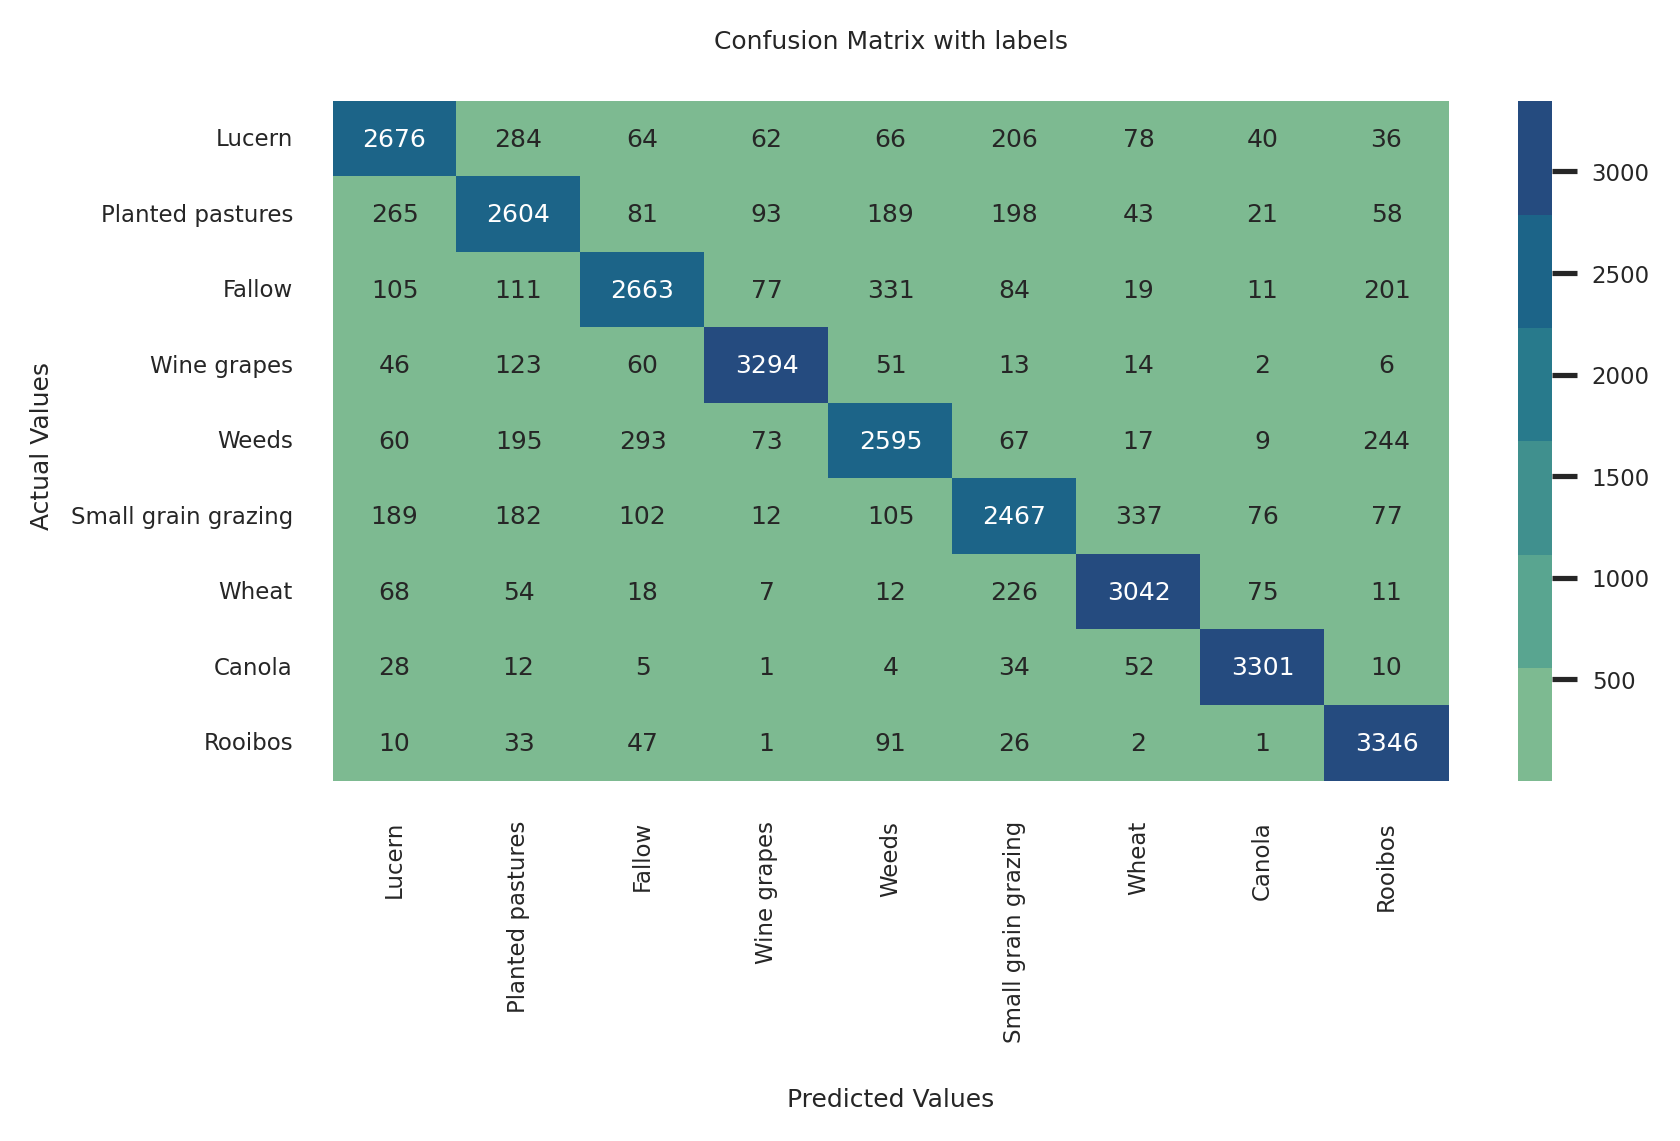

In [145]:
# build the confusion matrix
xgb_cm = confusion_matrix(y_val, y_pred_val)

# set the class labels to the actual crop types
labels = [
          'Lucern', 
          'Planted pastures', 
          'Fallow', 
          'Wine grapes', 
          'Weeds', 
          'Small grain grazing', 
          'Wheat', 
          'Canola', 
          'Rooibos'
]

# plot the confusion matrix of the validation data
plot_confusion_matrix(xgb_cm, labels)

From the confusion matrix we can see that:
- `Lucerne (1)` are often misclassified as `Planted pastures (2)` and `Small grain grazing (6)`.
- `Planted pastures (2)` are often misclassified as `Lucerne (1)`, `Weeds (5)` and `Small grain grazing (6)`.
- `Fallow (3)` are often misclassified as `Weeds (5)` and `Rooibos (9)`.
- `Wine grapes (4)` are rarely misclassified.
- `Weeds (5)` are often misclassified as `Planted pastures (2)`, `Fallow (3)` and `Rooibos (9)`.
- `Small grain grazing (6)` are often misclassified as `Lucerne (1)`, `Planted pastures (2)` and `Wheat (7)`.
- `Wheat (7)` are often misclassified as `Small grain grazing (6)`.
- `Canola (8)` are rarely misclassified.
- `Rooibos (9)` are rarely misclassified as `Weeds (5)`.



We can dive deeper and look at the accuracy of each class. And also with which class each class is most often confused.

In [143]:
def get_label_accuracies(xgb_cm, labels):
  accuracies = []
  often_confused_with = []
  confusion_percent = []

  for idx, label in enumerate(labels):
    # calculate the accuracy for the current label
    highest_value = np.diagonal(xgb_cm)[idx]
    sum_of_labels = np.sum(xgb_cm[idx])
    label_accuracy = round(highest_value/sum_of_labels, 2)
    accuracies.append(label_accuracy)

    # identify the label that the current one is most often confused with
    second_highest_value = np.partition(xgb_cm[idx].flatten(), -2)[-2]
    second_highest_value_idx = (np.where(xgb_cm[idx] == second_highest_value))
    often_confused_with.append(labels[int(second_highest_value_idx[0])])

    # get the confusion in percentage
    confusion = round(second_highest_value/highest_value*100, 2)
    confusion_percent.append(confusion)

  # create a data frame using a dictionary
  data = {
      'crop_type':labels, 
      'accuracy':accuracies,
      'often_confused_with':often_confused_with,
      'confusion_percent':confusion_percent
      }
  acc_df = pd.DataFrame(data)

  # sort the data frame in order decreasing feature importance
  acc_df.sort_values(by=['accuracy'], ascending=False, inplace=True)

  return acc_df

In [147]:
accuracies_df = get_label_accuracies(xgb_cm, labels)
accuracies_df

,crop_type,accuracy,often_confused_with,confusion_percent
7,Canola,0.96,Wheat,1.58
8,Rooibos,0.94,Weeds,2.72
3,Wine grapes,0.91,Planted pastures,3.73
6,Wheat,0.87,Small grain grazing,7.43
0,Lucern,0.76,Planted pastures,10.61
2,Fallow,0.74,Weeds,12.43
1,Planted pastures,0.73,Lucern,10.18
4,Weeds,0.73,Fallow,11.29
5,Small grain grazing,0.70,Wheat,13.66


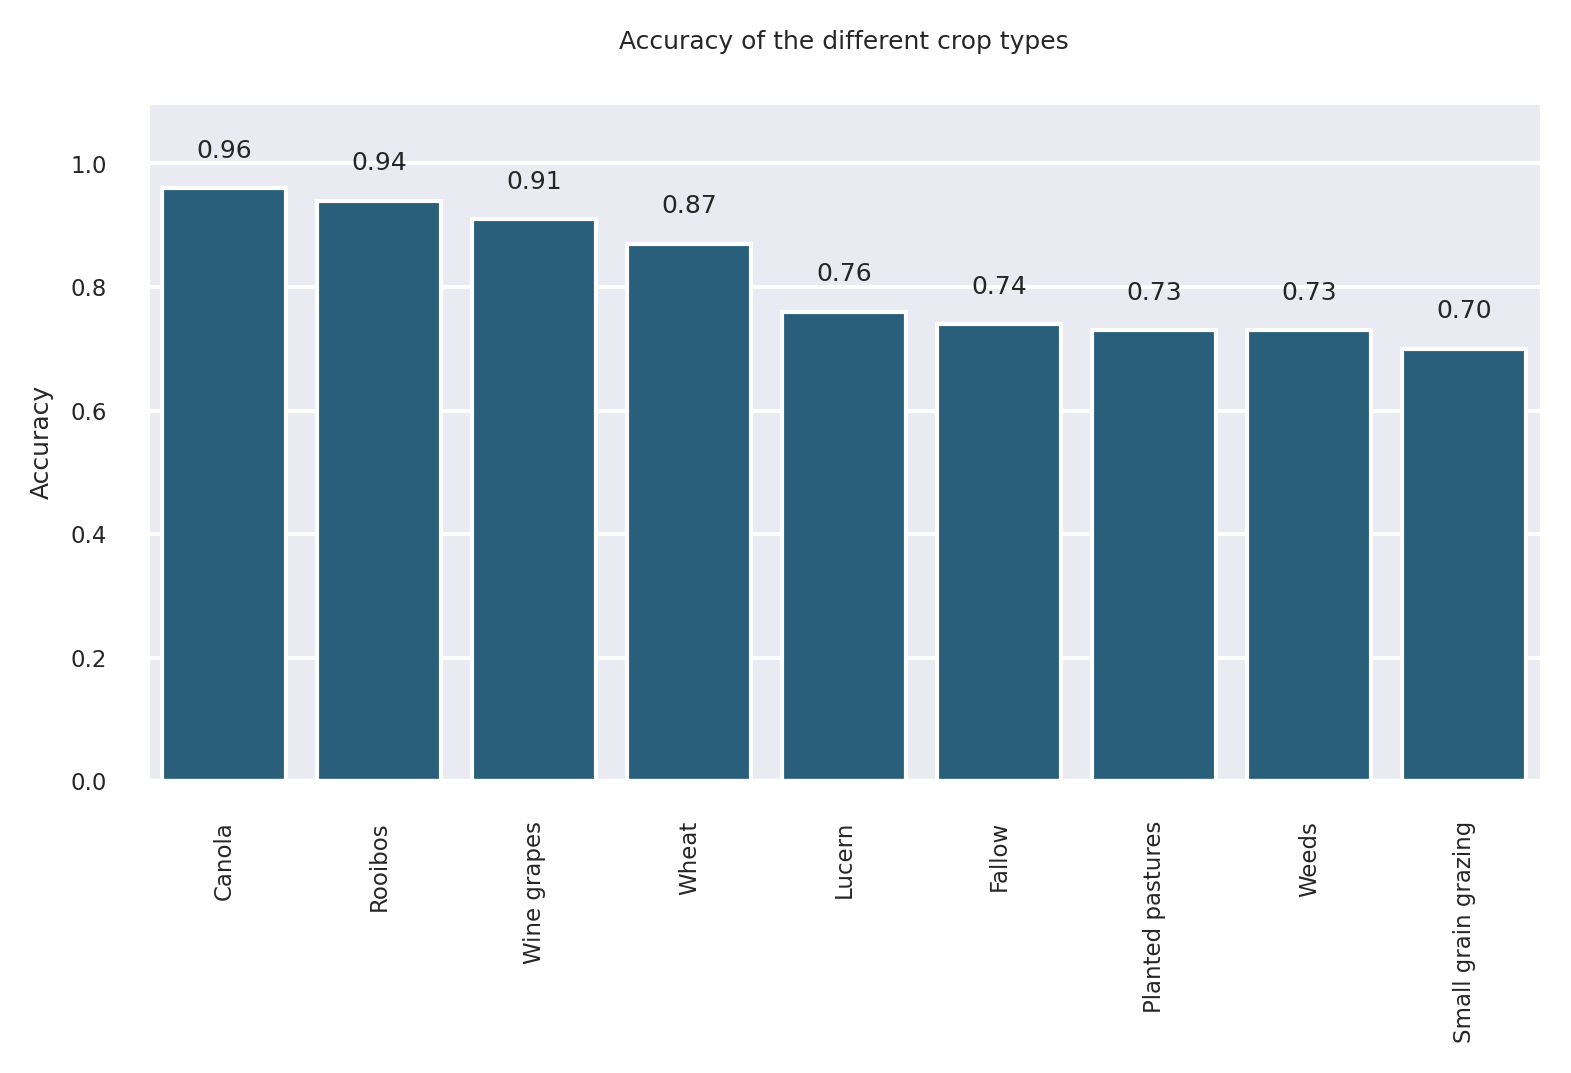

In [161]:
def plot_label_accuracy(df):

  # plot Searborn bar chart
  ax = sns.barplot(data=df, x='crop_type', y='accuracy', color=cmap[4])

  # do the annotation on each bar
  for bar in ax.patches:
      ax.annotate(format(bar.get_height(), '.2f'), 
                    (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

  # set chart labels
  ax.set_title('Accuracy of the different crop types\n')
  ax.set_xlabel('')
  ax.set_ylabel('Accuracy')

  # set the ticket labels
  plt.yticks(rotation=0) 
  plt.ylim(0, 1.1)
  plt.xticks(rotation=90, horizontalalignment='center')


  plt.show()

plot_label_accuracy(accuracies_df)

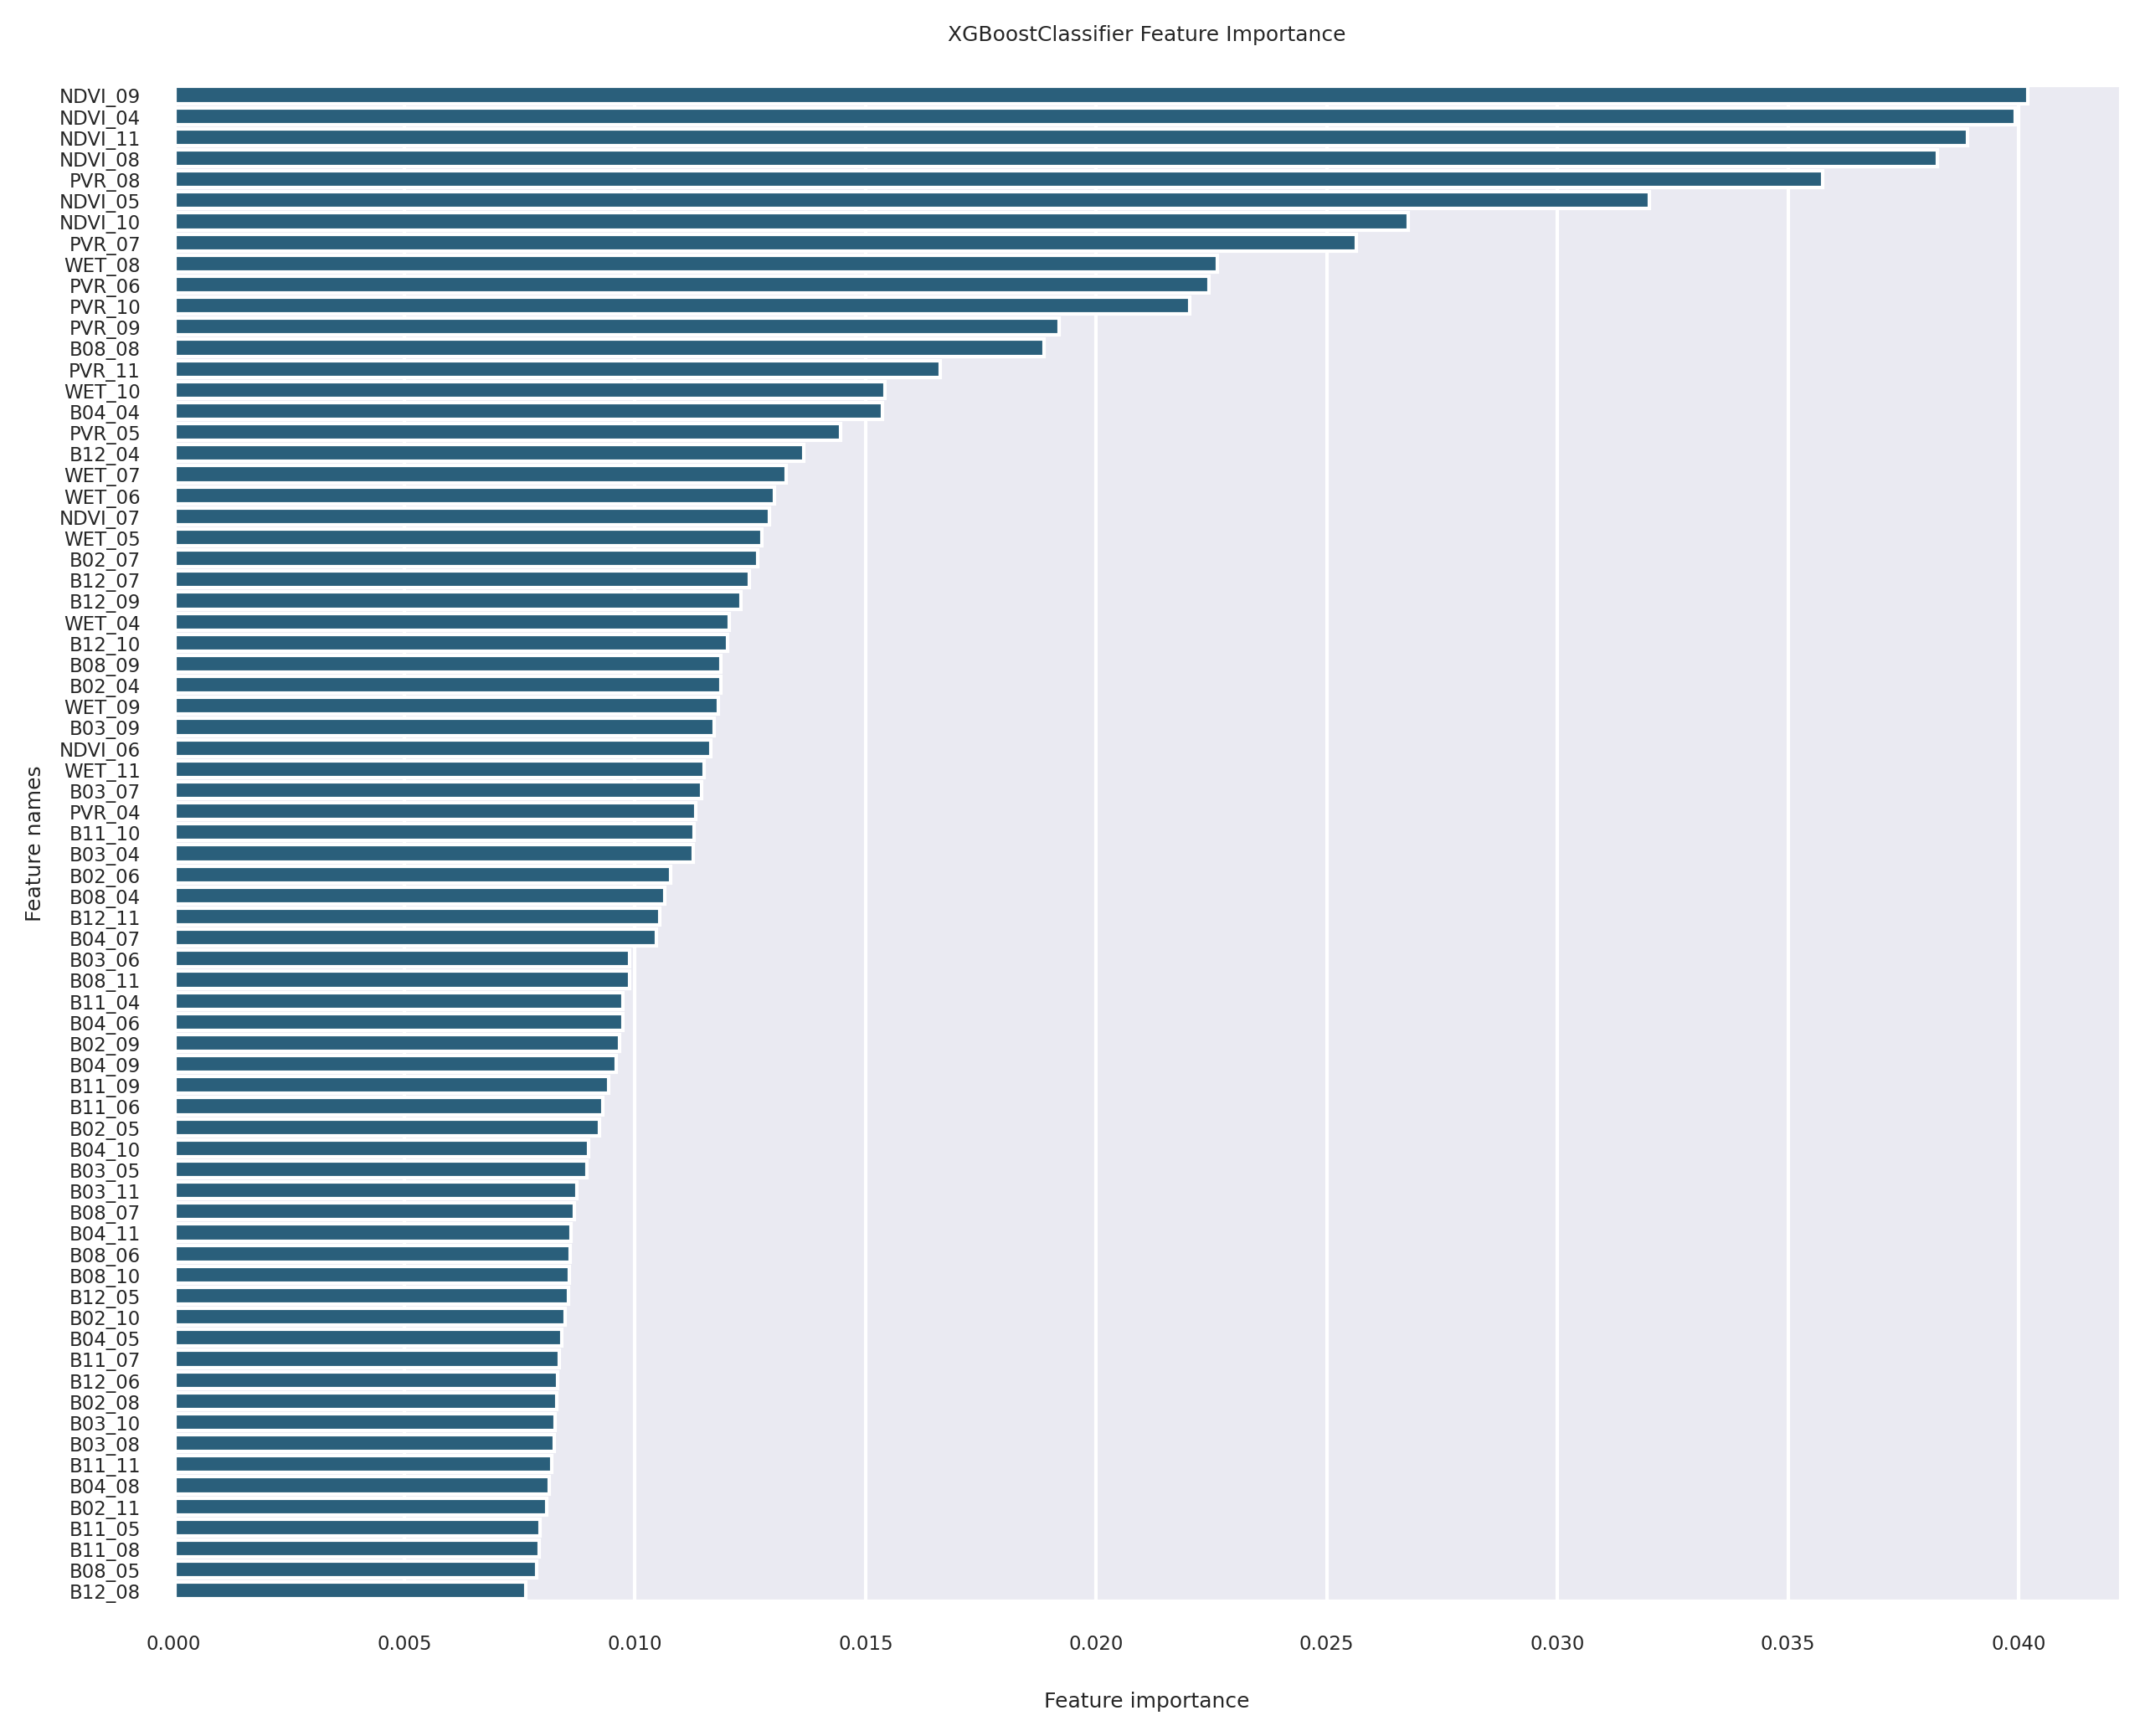

In [160]:
def plot_feature_importance(importance, feature_names, model_name):
  # create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(feature_names)

  # create a data frame using a dictionary
  data={'feature_names':feature_names, 'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  # sort the data frame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
  
  # define size of bar plot
  plt.figure(figsize=(10,8))

  # plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], color=cmap[4])

  # set chart labels
  plt.title(f"{model_name} Feature Importance\n")
  plt.xlabel('\nFeature importance')
  plt.ylabel('Feature names')

plot_feature_importance(xgb.feature_importances_, X_val.columns, 'XGBoostClassifier')

---
### 